---
## 1️⃣ Chargement des Données

# 🎭 Analyse de Sentiment Twitter
## Classification automatique de sentiments (Positif/Négatif/Neutre)

**Objectif :** Créer un modèle de machine learning pour analyser le sentiment des tweets  
**Dataset :** Twitter Sentiment Data  
**Date :** October 2025

---

### 📋 Table des matières
1. **Chargement des données**
2. **Nettoyage et exploration**
3. **Preprocessing du texte**
4. **Labelling avec VADER**
5. **Vectorisation TF-IDF**
6. **Entraînement des modèles**
7. **Évaluation et comparaison**
8. **Sauvegarde et test**

In [1]:
# Chargement du dataset
import pandas as pd
from pathlib import Path
import os

# Chemin vers le fichier dans le répertoire /content
data_path = Path("/content") / "my_data.csv"

print(f"🔍 Recherche du fichier : {data_path}")

# Vérifier si le fichier existe
if data_path.exists():
    # Utiliser error_bad_lines=False et engine='python' pour gérer les lignes mal formatées
    data = pd.read_csv(data_path, sep=',', on_bad_lines='skip', engine='python')
    print(f"✅ Données chargées : {data.shape[0]} lignes × {data.shape[1]} colonnes")
    display(data.head())
else:
    print(f"❌ Fichier introuvable à : {data_path}")
    print("\n💡 Solutions possibles :")
    print("   1. Vérifiez que le fichier s'appelle exactement 'my_data.csv'")
    print(f"   2. Vérifiez qu'il est bien dans le répertoire '/content'. Votre répertoire actuel : {os.getcwd()}")
    data = None

🔍 Recherche du fichier : /content/my_data.csv
✅ Données chargées : 20003 lignes × 10 colonnes


,,Tweet,Author Bio,Followers,Retweets,Favorites,Tweet ID,Author ID,Created At,Language
0,0,"One of our Partners, Shirley Ley, shares her t...",We are an executive search firm working with c...,128.0,0.0,0.0,1635264672852221952,1.357020e+18,Mon Mar 13 13:00:54 +0000 2023,en
1,1,Today’s conversation starter: How do you feel ...,Savvy Cyber Kids teaches #privacy #cyberethics...,2932.0,0.0,4.0,1635250618284789760,3.761202e+08,Mon Mar 13 12:05:03 +0000 2023,en
2,2,RT @rmdscreations: Ice Breakers for those who ...,"I am an artist. My designs, art, work availabl...",726.0,1.0,0.0,1635198290991136768,1.450120e+18,Mon Mar 13 08:37:07 +0000 2023,en
3,3,RT @rmdscreations: Ice Breakers for those who ...,USA-made 🇺🇸 #OLenaArt #Artist #art #pollock...,628.0,3.0,0.0,1634933581406695426,1.526558e+18,Sun Mar 12 15:05:16 +0000 2023,en
4,4,RT @rmdscreations: Ice Breakers for those who ...,Coloring the world #abstract #art #photography...,21900.0,3.0,0.0,1634879882269163521,2.887594e+07,Sun Mar 12 11:31:53 +0000 2023,en


In [2]:
# Vérification des valeurs manquantes
print("📊 Valeurs manquantes par colonne :")
print(data.isnull().sum())

# Suppression des colonnes inutiles
data = data.drop(['Author Bio', 'Followers', 'Retweets',
                  'Favorites', 'Tweet ID', 'Author ID', 'Created At'], axis=1)

print(f"\n✅ Colonnes supprimées. Nouvelles dimensions : {data.shape}")

📊 Valeurs manquantes par colonne :
                 0
Tweet            0
Author Bio    3069
Followers        0
Retweets         0
Favorites        0
Tweet ID         0
Author ID        0
Created At       0
Language         0
dtype: int64

✅ Colonnes supprimées. Nouvelles dimensions : (20003, 3)


---
## 2️⃣ Nettoyage et Exploration des Données

In [3]:
# Distribution des langues dans le dataset
print("🌍 Distribution des langues :")
print(data['Language'].value_counts())

🌍 Distribution des langues :
Language
en     17744
es       383
fr       323
in       320
und      292
hi       199
ja       145
tl       140
zh        81
pt        65
th        49
et        36
ko        36
ar        29
de        27
it        16
tr        15
ta        15
cy        13
pl        11
nl         7
ur         7
sv         5
da         5
ru         4
mr         4
fa         4
el         3
vi         3
ca         3
ht         3
pa         2
cs         2
no         2
kn         2
uk         1
gu         1
sl         1
sr         1
lv         1
ml         1
ro         1
bn         1
Name: count, dtype: int64


In [4]:
# Filtrer uniquement les tweets en anglais
initial_count = len(data)
data = data[data['Language'] == "en"]
filtered_count = len(data)

print(f"✅ Tweets en anglais : {initial_count} → {filtered_count} ({filtered_count/initial_count*100:.1f}%)")
print(f"Langues uniques restantes : {data['Language'].unique()}")

✅ Tweets en anglais : 20003 → 17744 (88.7%)
Langues uniques restantes : ['en']


In [5]:
# Aperçu des données nettoyées
print("📋 Aperçu des premières lignes :")
data.head()

📋 Aperçu des premières lignes :


,,Tweet,Language
0,0,"One of our Partners, Shirley Ley, shares her t...",en
1,1,Today’s conversation starter: How do you feel ...,en
2,2,RT @rmdscreations: Ice Breakers for those who ...,en
3,3,RT @rmdscreations: Ice Breakers for those who ...,en
4,4,RT @rmdscreations: Ice Breakers for those who ...,en


---
## 3️⃣ Preprocessing du Texte

### Étapes :
1. Suppression des URLs et hashtags
2. Remplacement des contractions (can't → cannot)
3. Suppression de la ponctuation
4. Conversion des emojis en texte
5. Lemmatization et suppression des stopwords

In [6]:
# Étape 1 : Suppression des URLs et hashtags
import re

def clean_text(text):
    """Supprime les URLs et hashtags du texte"""
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'#\S+', '', text, flags=re.MULTILINE)
    return text

data['Tweet'] = data['Tweet'].apply(clean_text)

print("✅ Étape 1/5 : URLs et hashtags supprimés")
print(f"Exemple : {data['Tweet'][1]}")

✅ Étape 1/5 : URLs et hashtags supprimés
Exemple : Today’s conversation starter: How do you feel about voice cloning technology?                   


In [7]:
# Étape 2 : Dictionnaire de contractions anglaises
contractions_dict = {
    "ain't": "are not", "'s": " is", "aren't": "are not",
    "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not",
    "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have", "i'm": "i am", "I've": "i have", "isn't": "is not",
    "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "that'd": "that would", "that'd've": "that would have", "there'd": "there would",
    "there'd've": "there would have", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what've": "what have",
    "when've": "when have", "where'd": "where did", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who've": "who have",
    "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are",
    "you've": "you have", "Today's": "Today is"
}

print(f"📚 Dictionnaire chargé : {len(contractions_dict)} contractions")

📚 Dictionnaire chargé : 107 contractions


In [8]:
# Étape 2 : Fonction pour remplacer les contractions
def replace_contractions(text):
    """Remplace les contractions par leur forme complète"""
    if not isinstance(text, str):
        return text
    for contraction, full_form in contractions_dict.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', full_form, text)
    return text

# Application sur la colonne "Tweet"
data['Tweet'] = data['Tweet'].apply(replace_contractions)

print("✅ Étape 2/5 : Contractions remplacées")
print(f"Exemple : {data['Tweet'][1]}")

✅ Étape 2/5 : Contractions remplacées
Exemple : Today’s conversation starter: How do you feel about voice cloning technology?                   


In [9]:
# Étape 3 : Supprimer la ponctuation et convertir en minuscules
import string

def punct_word(text):
    """Supprime la ponctuation et convertit en minuscules"""
    return ("".join([i.lower() for i in text if i not in string.punctuation])).strip()

data["Tweet"] = data["Tweet"].apply(punct_word)

print("✅ Étape 3/5 : Ponctuation supprimée et texte en minuscules")
print(f"Exemple : {data['Tweet'][1]}")

✅ Étape 3/5 : Ponctuation supprimée et texte en minuscules
Exemple : today’s conversation starter how do you feel about voice cloning technology


In [10]:
# Étape 4 : Vérifier la présence d'emojis
import demoji
import emoji

emoji_result = data["Tweet"].apply(lambda x: demoji.findall(x))
emoji_count = sum(1 for item in emoji_result.tolist() if item)

print(f"✅ Étape 4/5 : Analyse des emojis")
print(f"📊 Tweets contenant des emojis : {emoji_count}")

# Afficher quelques exemples
if emoji_count > 0:
    print("\n📝 Exemples d'emojis trouvés :")
    count = 0
    for item in emoji_result.tolist():
        if item and count < 5:
            print(f"   • {item}")
            count += 1

✅ Étape 4/5 : Analyse des emojis
📊 Tweets contenant des emojis : 2670

📝 Exemples d'emojis trouvés :
   • {'💥': 'collision'}
   • {'🌟': 'glowing star', '🔥': 'fire', '💬': 'speech balloon', '📝': 'memo'}
   • {'💭': 'thought balloon'}
   • {'🙌🏼': 'raising hands: medium-light skin tone'}
   • {'💬': 'speech balloon'}


In [11]:
!pip install emoji

In [12]:
# Transformer les emojis en texte descriptif
data["Tweet"] = data["Tweet"].astype(str).apply(lambda x: emoji.demojize(x, delimiters=(' ', ' ')))

print("✅ Emojis convertis en texte")
print(f"Exemple : {data['Tweet'][1]}")

✅ Emojis convertis en texte
Exemple : today’s conversation starter how do you feel about voice cloning technology


In [13]:
# Étape 5 : Tokenization, Lemmatization et suppression des stopwords
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Télécharger les ressources NLTK (silencieux si déjà présentes)
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialisation des outils NLTK
tokenizer = RegexpTokenizer(r'\w+')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

print(f"✅ Étape 5/5 : Outils NLTK chargés")
print(f"📚 Stopwords anglais : {len(stopwords)} mots")

✅ Étape 5/5 : Outils NLTK chargés
📚 Stopwords anglais : 198 mots


In [14]:
# Fonction de lemmatization complète
def lemmatize_sentence(sentence):
    """
    Tokenize, supprime stopwords et applique lemmatization

    Args:
        sentence: Phrase à traiter
    Returns:
        Phrase lemmatisée nettoyée
    """
    # Tokenize
    tokens = tokenizer.tokenize(sentence.lower())

    # Supprimer stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords]

    # Appliquer lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(lemmatized_tokens)

# Application sur tous les tweets
print("🔄 Application de la lemmatization (peut prendre du temps)...")
data["Tweet"] = data["Tweet"].apply(lemmatize_sentence)

print("✅ Preprocessing terminé!")
print(f"📊 Exemple final : {data['Tweet'][1]}")

🔄 Application de la lemmatization (peut prendre du temps)...
✅ Preprocessing terminé!
📊 Exemple final : today conversation starter feel voice cloning technology


/tmp/ipython-input-4027036151.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4027036151.py:36: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


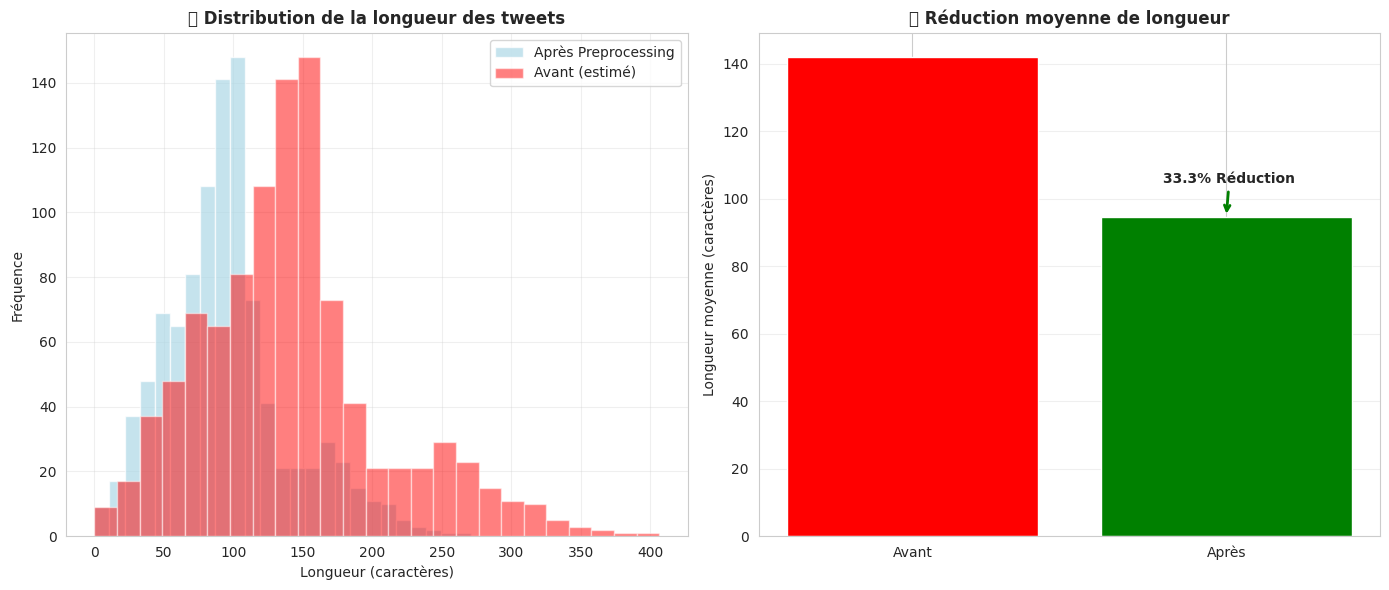

💡 Réduction: 142 → 95 caractères (33.3% de réduction)


In [15]:
# Visualisation avant/après le stemming
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sample = data.sample(min(1000, len(data)), random_state=42)
lengths_after = sample['Tweet'].str.len()
mean_after = np.mean(lengths_after)

# Simulation "avant" (estimation)
lengths_before = lengths_after * 1.5
reduction_pct = ((np.mean(lengths_before) - mean_after) / np.mean(lengths_before)) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme avant/après
ax1.hist(lengths_after, bins=25, alpha=0.7, color='lightblue', label='Après Preprocessing')
ax1.hist(lengths_before, bins=25, alpha=0.5, color='red', label='Avant (estimé)')
ax1.set_title('📊 Distribution de la longueur des tweets', fontweight='bold', fontsize=12)
ax1.set_xlabel('Longueur (caractères)')
ax1.set_ylabel('Fréquence')
ax1.legend()
ax1.grid(alpha=0.3)

# Barplot réduction
ax2.bar(['Avant', 'Après'], [np.mean(lengths_before), mean_after], color=['red', 'green'])
ax2.annotate(f'{reduction_pct:.1f}% Réduction',
             xy=(1, mean_after), xytext=(0.8, mean_after + 10),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontweight='bold')
ax2.set_title('📉 Réduction moyenne de longueur', fontweight='bold', fontsize=12)
ax2.set_ylabel('Longueur moyenne (caractères)')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"💡 Réduction: {np.mean(lengths_before):.0f} → {mean_after:.0f} caractères ({reduction_pct:.1f}% de réduction)")

### 📊 Visualisation de l'impact du preprocessing

In [16]:
# Analyse de sentiment avec VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def predire_polarite(content):
    """
    Prédit le sentiment d'un texte avec VADER

    Args:
        content: Texte à analyser
    Returns:
        'Positive', 'Negative' ou 'Neutral'
    """
    analyser = SentimentIntensityAnalyzer()
    scores = analyser.polarity_scores(content)
    polarite = scores['compound']

    if polarite > 0.05:
        sentiment = 'Positive'
    elif polarite < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment

# Application sur tous les tweets
print("🔄 Labelling des sentiments avec VADER...")
data["Tweet_sentiment"] = data["Tweet"].astype(str).apply(predire_polarite)

# Statistiques
sentiment_counts = data['Tweet_sentiment'].value_counts()
print("\n📊 Distribution des sentiments :")
for sentiment, count in sentiment_counts.items():
    pct = (count / len(data)) * 100
    print(f"   • {sentiment:10s}: {count:6,} ({pct:5.1f}%)")

print("\n✅ Labelling terminé!")

🔄 Labelling des sentiments avec VADER...

📊 Distribution des sentiments :
   • Negative  :  8,243 ( 46.5%)
   • Positive  :  7,598 ( 42.8%)
   • Neutral   :  1,903 ( 10.7%)

✅ Labelling terminé!


In [17]:
!pip install vaderSentiment

---
## 4️⃣ Labelling de Sentiment avec VADER

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) est un outil spécialisé pour l'analyse de sentiment des textes courts et des médias sociaux.

In [18]:
# Aperçu des données avec sentiments
print("📋 Aperçu des données labellisées :")
data

📋 Aperçu des données labellisées :


,,Tweet,Language,Tweet_sentiment
0,0,one partner shirley ley share thought investing,en,Positive
1,1,today conversation starter feel voice cloning ...,en,Neutral
2,2,rt rmdscreations ice breaker hate small talk h...,en,Negative
3,3,rt rmdscreations ice breaker hate small talk r...,en,Positive
4,4,rt rmdscreations ice breaker hate small talk r...,en,Positive
...,...,...,...,...
19998,495,lindseyinco lukethelib mmpadellan mayor nyc wo...,en,Negative
19999,496,rt itsthedr justin trudeau worthless pile pile...,en,Negative
20000,497,rt authorthomasm hey ally bank point good time...,en,Positive
20001,498,feel worthless deserve live gained love overre...,en,Positive


/tmp/ipython-input-127469133.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-127469133.py:27: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


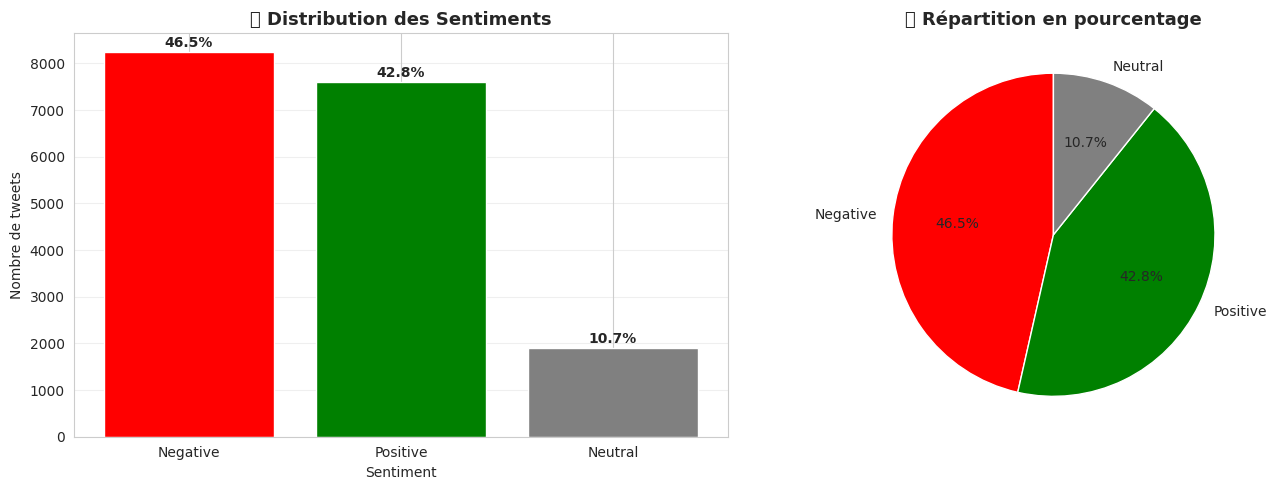

In [19]:
# Visualisation de la distribution des sentiments
import matplotlib.pyplot as plt

sentiment_counts = data['Tweet_sentiment'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'gray'}
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'blue') for x in sentiment_counts.index])
ax1.set_title('📊 Distribution des Sentiments', fontweight='bold', fontsize=13)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Nombre de tweets')
ax1.grid(axis='y', alpha=0.3)

# Ajouter pourcentages sur barres
for i, (sentiment, count) in enumerate(sentiment_counts.items()):
    pct = (count / len(data)) * 100
    ax1.text(i, count + 100, f'{pct:.1f}%', ha='center', fontweight='bold')

# Pie chart
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=[colors.get(x, 'blue') for x in sentiment_counts.index], startangle=90)
ax2.set_title('🥧 Répartition en pourcentage', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

In [20]:
# Vectorisation TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(
    max_features=5000,      # Top 5000 mots
    ngram_range=(1, 2),     # Unigrammes + bigrammes
    min_df=2,               # Mots apparaissant au moins 2 fois
    max_df=0.9              # Ignorer mots trop fréquents
)

print("🔄 Vectorisation TF-IDF en cours...")
X = tfidf_v.fit_transform(data['Tweet'].values.astype('U'))
y = data['Tweet_sentiment']

print(f"\n✅ Vectorisation terminée!")
print(f"   📊 Shape de X: {X.shape}")
print(f"   📚 Vocabulaire: {len(tfidf_v.vocabulary_):,} mots uniques")
print(f"   💾 Sparse matrix size: {X.data.nbytes / 1024**2:.2f} MB")

🔄 Vectorisation TF-IDF en cours...

✅ Vectorisation terminée!
   📊 Shape de X: (17744, 5000)
   📚 Vocabulaire: 5,000 mots uniques
   💾 Sparse matrix size: 1.77 MB


---
## 5️⃣ Vectorisation TF-IDF

**TF-IDF** (Term Frequency-Inverse Document Frequency) transforme le texte en représentation numérique pour l'entraînement des modèles.

In [21]:
# Encodage des labels (Positive/Negative/Neutral → 0/1/2)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['Tweet_sentiment'] = encoder.fit_transform(data['Tweet_sentiment'])

print("📊 Encodage des labels :")
classes = encoder.classes_
for idx, label in enumerate(classes):
    print(f"   • {label:10s} → {idx}")

print(f"\n✅ Labels encodés")

📊 Encodage des labels :
   • Negative   → 0
   • Neutral    → 1
   • Positive   → 2

✅ Labels encodés


In [22]:
# Vérification du mapping des classes
classes = encoder.classes_
encoding_mapping = {class_label: index for index, class_label in enumerate(classes)}

print("📋 Mapping complet :")
print(f"   Classes: {classes}")
print(f"   Encodage: {encoding_mapping}")

# Sauvegarder l'encoder (optionnel, à décommenter si nécessaire)
import pickle
# pickle.dump(encoder, open('label_encoder.pkl', "wb"))
print("\n💡 Pour sauvegarder l'encoder, décommenter la ligne ci-dessus")

📋 Mapping complet :
   Classes: ['Negative' 'Neutral' 'Positive']
   Encodage: {'Negative': 0, 'Neutral': 1, 'Positive': 2}

💡 Pour sauvegarder l'encoder, décommenter la ligne ci-dessus


In [23]:
# Split Train/Test avec stratification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, data['Tweet_sentiment'], # Utiliser la colonne encodée pour y
    test_size=0.2,
    random_state=5,
    stratify=data['Tweet_sentiment']  # Stratifier sur la colonne encodée
)

print("📊 SPLIT DES DONNÉES")
print("="*50)
print(f"   Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(data)*100:.1f}%)")
print(f"   Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(data)*100:.1f}%)")
print(f"\n   Shape X_train: {X_train.shape}")
print(f"   Shape y_train: {y_train.shape}")
print(f"\n✅ Données prêtes pour l'entraînement!")

📊 SPLIT DES DONNÉES
   Train set: 14,195 samples (80.0%)
   Test set:  3,549 samples (20.0%)

   Shape X_train: (14195, 5000)
   Shape y_train: (14195,)

✅ Données prêtes pour l'entraînement!


---
## 6️⃣ Split Train/Test avec Stratification

In [24]:
# Entraînement Random Forest
from sklearn.ensemble import RandomForestClassifier
import time

print("🌲 RANDOM FOREST")
print("="*50)

start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=5, n_jobs=-1)
rf.fit(X_train, y_train)
train_time = time.time() - start_time

pred_rf = rf.predict(X_test)

print(f"✅ Modèle entraîné en {train_time:.2f}s")
print(f"   Prédictions shape: {pred_rf.shape}")

🌲 RANDOM FOREST
✅ Modèle entraîné en 15.45s
   Prédictions shape: (3549,)


---
## 7️⃣ Entraînement des Modèles

### 🌲 Modèle 1 : Random Forest

In [25]:
# Cross-validation sur Random Forest
from sklearn.model_selection import cross_val_score

print("🔄 Cross-validation (5-fold)...")
score = cross_val_score(
    RandomForestClassifier(n_estimators=200, random_state=5),
    X_train, y_train,
    cv=5
).mean()

print(f"✅ Score moyen CV: {score:.4f}")

🔄 Cross-validation (5-fold)...
✅ Score moyen CV: 0.8423


📊 ÉVALUATION - RANDOM FOREST
Accuracy: 0.8501

Rapport de classification:
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1649
     Neutral       0.73      0.66      0.70       380
    Positive       0.87      0.85      0.86      1520

    accuracy                           0.85      3549
   macro avg       0.82      0.80      0.81      3549
weighted avg       0.85      0.85      0.85      3549



/tmp/ipython-input-4227267953.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


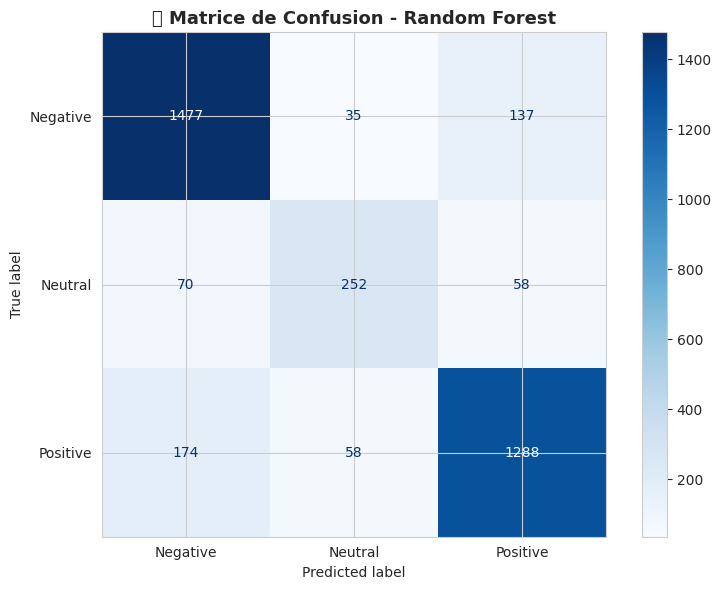

In [26]:
# Évaluation Random Forest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import metrics

print("📊 ÉVALUATION - RANDOM FOREST")
print("="*50)
print(f'Accuracy: {metrics.accuracy_score(y_test, pred_rf):.4f}')
print(f'\nRapport de classification:')
print(classification_report(y_test, pred_rf, target_names=encoder.classes_))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf, display_labels=encoder.classes_, ax=ax, cmap='Blues')
ax.set_title('📊 Matrice de Confusion - Random Forest', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

In [27]:
# Entraînement Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier

print("🎯 PASSIVE AGGRESSIVE CLASSIFIER")
print("="*50)

start_time = time.time()
pac = PassiveAggressiveClassifier(max_iter=500, random_state=42)
pac.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_PassiveAggressive = pac.predict(X_test)

print(f"✅ Modèle entraîné en {train_time:.2f}s")

🎯 PASSIVE AGGRESSIVE CLASSIFIER
✅ Modèle entraîné en 0.17s


### 🎯 Modèle 2 : Passive Aggressive Classifier

📊 ÉVALUATION - PASSIVE AGGRESSIVE
Accuracy: 0.8633

Rapport de classification:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      1649
     Neutral       0.72      0.66      0.69       380
    Positive       0.86      0.90      0.88      1520

    accuracy                           0.86      3549
   macro avg       0.83      0.81      0.82      3549
weighted avg       0.86      0.86      0.86      3549



/tmp/ipython-input-511441055.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


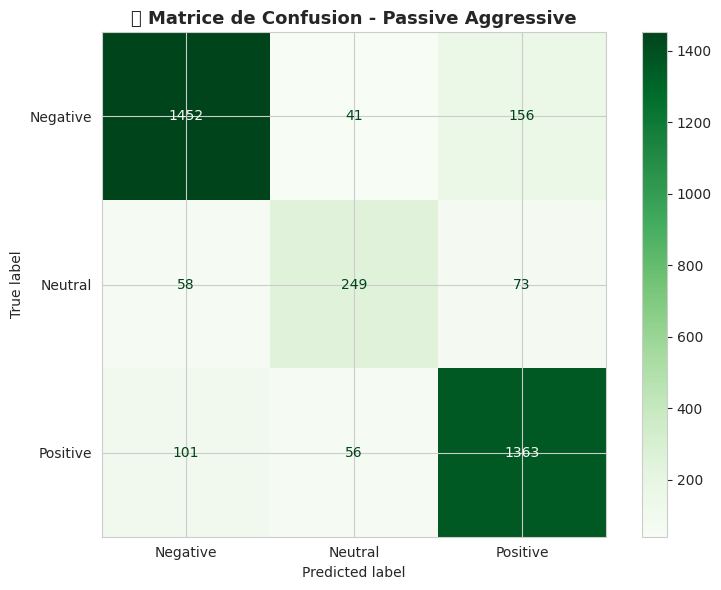

In [28]:
# Évaluation Passive Aggressive
print("📊 ÉVALUATION - PASSIVE AGGRESSIVE")
print("="*50)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_PassiveAggressive):.4f}')
print(f'\nRapport de classification:')
print(classification_report(y_test, y_pred_PassiveAggressive, target_names=encoder.classes_))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_PassiveAggressive,
                                        display_labels=encoder.classes_, ax=ax, cmap='Greens')
ax.set_title('📊 Matrice de Confusion - Passive Aggressive', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

In [29]:
# Entraînement Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

print("📊 NAIVE BAYES (MultinomialNB)")
print("="*50)

start_time = time.time()
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"✅ Modèle entraîné en {train_time:.2f}s")
print(f"📊 Accuracy: {accuracy_nb:.4f}")

📊 NAIVE BAYES (MultinomialNB)
✅ Modèle entraîné en 0.00s
📊 Accuracy: 0.7977


### 📊 Modèle 3 : Naive Bayes (MultinomialNB)

In [30]:
# Entraînement XGBoost
import numpy as np
import xgboost as xgb

print("🚀 XGBOOST")
print("="*50)

start_time = time.time()
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
model_xgb.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"✅ Modèle entraîné en {train_time:.2f}s")
print(f"📊 Accuracy: {accuracy_xgb:.4f}")

🚀 XGBOOST


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:36:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle entraîné en 10.96s
📊 Accuracy: 0.8487


In [31]:
# Comparaison de tous les modèles
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics # Ensure metrics is imported here

print("📊 TABLEAU COMPARATIF DES MODÈLES")
print("="*80)

results = []

# Convert predictions to integer type to avoid type errors
pred_rf_int = pred_rf.astype(int)
y_pred_PassiveAggressive_int = y_pred_PassiveAggressive.astype(int)
y_pred_nb_int = y_pred_nb.astype(int)
y_pred_xgb_int = y_pred_xgb.astype(int)


# Random Forest
results.append({
    'Modèle': 'Random Forest',
    'Accuracy': metrics.accuracy_score(y_test, pred_rf_int),
    'F1-Score': f1_score(y_test, pred_rf_int, average='weighted'),
    'Precision': precision_score(y_test, pred_rf_int, average='weighted'),
    'Recall': recall_score(y_test, pred_rf_int, average='weighted')
})

# Passive Aggressive
results.append({
    'Modèle': 'Passive Aggressive',
    'Accuracy': metrics.accuracy_score(y_test, y_pred_PassiveAggressive_int),
    'F1-Score': f1_score(y_test, y_pred_PassiveAggressive_int, average='weighted'),
    'Precision': precision_score(y_test, y_pred_PassiveAggressive_int, average='weighted'),
    'Recall': recall_score(y_test, y_pred_PassiveAggressive_int, average='weighted')
})

# Naive Bayes
results.append({
    'Modèle': 'Naive Bayes',
    'Accuracy': accuracy_nb,
    'F1-Score': f1_score(y_test, y_pred_nb_int, average='weighted'),
    'Precision': precision_score(y_test, y_pred_nb_int, average='weighted'),
    'Recall': recall_score(y_test, y_pred_nb_int, average='weighted')
})

# XGBoost
results.append({
    'Modèle': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'F1-Score': f1_score(y_test, y_pred_xgb_int, average='weighted'),
    'Precision': precision_score(y_test, y_pred_xgb_int, average='weighted'),
    'Recall': recall_score(y_test, y_pred_xgb_int, average='weighted')
})

# Créer DataFrame et trier
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Modèle']
best_f1 = results_df.iloc[0]['F1-Score']

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   📊 F1-Score: {best_f1:.4f}")
print(f"   📊 Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

📊 TABLEAU COMPARATIF DES MODÈLES
            Modèle  Accuracy  F1-Score  Precision   Recall
Passive Aggressive  0.863342  0.862511   0.862517 0.863342
     Random Forest  0.850099  0.849106   0.848946 0.850099
           XGBoost  0.848690  0.845554   0.847298 0.848690
       Naive Bayes  0.797689  0.782422   0.808097 0.797689

🏆 MEILLEUR MODÈLE: Passive Aggressive
   📊 F1-Score: 0.8625
   📊 Accuracy: 0.8633


/tmp/ipython-input-3355280517.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3355280517.py:38: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


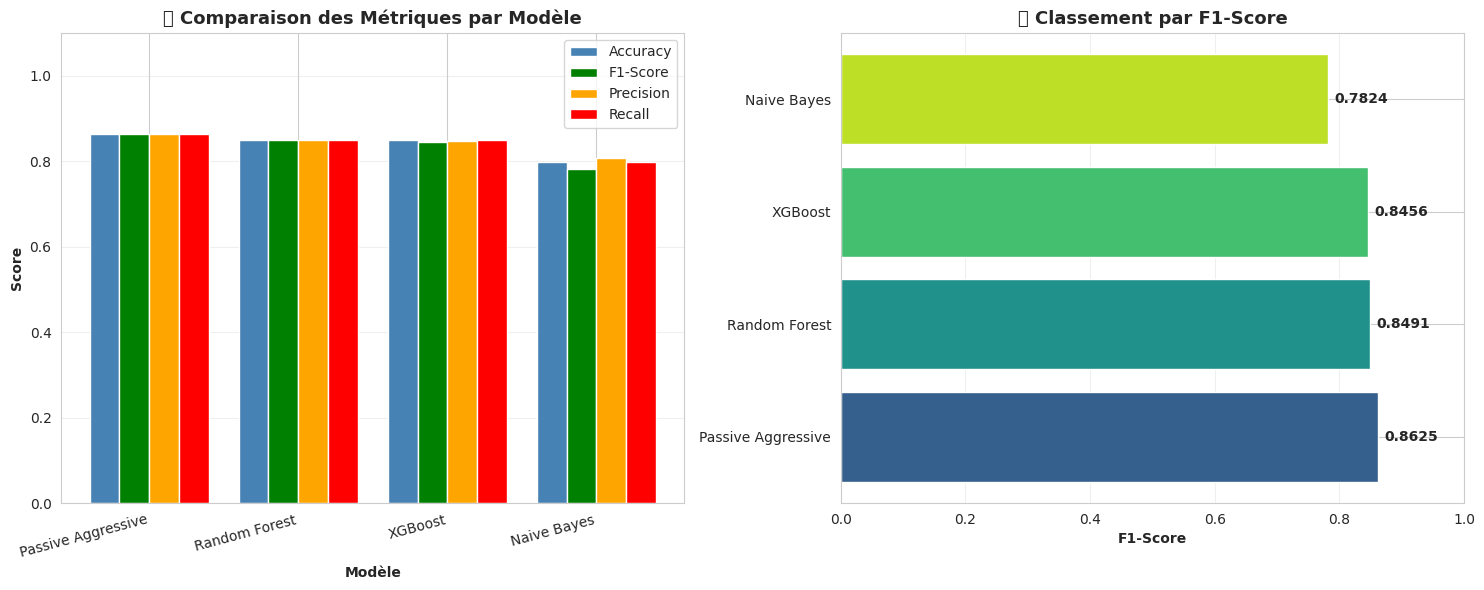

In [32]:
# Visualisation comparative des performances
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1: Barplot des métriques
ax1 = axes[0]
x = np.arange(len(results_df))
width = 0.2

bars1 = ax1.bar(x - width*1.5, results_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax1.bar(x - width*0.5, results_df['F1-Score'], width, label='F1-Score', color='green')
bars3 = ax1.bar(x + width*0.5, results_df['Precision'], width, label='Precision', color='orange')
bars4 = ax1.bar(x + width*1.5, results_df['Recall'], width, label='Recall', color='red')

ax1.set_xlabel('Modèle', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('📊 Comparaison des Métriques par Modèle', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Modèle'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.1)

# Graphique 2: F1-Score horizontal bar
ax2 = axes[1]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(results_df)))
bars = ax2.barh(results_df['Modèle'], results_df['F1-Score'], color=colors)
ax2.set_xlabel('F1-Score', fontweight='bold')
ax2.set_title('🏆 Classement par F1-Score', fontweight='bold', fontsize=13)
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim(0, 1)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8️⃣ Comparaison des Modèles

### 🚀 Modèle 4 : XGBoost

In [33]:
# Test de prédiction sur un nouveau tweet
Tweet = {"Tweet": ["Sometimes, the most beautiful paths are the ones we never planned to take. Trust the timing of your life—everything will fall into place. 💫❤️"]}
data_Tweet = pd.DataFrame(Tweet)

# Vectorisation du nouveau tweet (doit utiliser le même vectorizer)
X_new = tfidf_v.transform(data_Tweet['Tweet'].values.astype('U'))

# Prédiction avec le meilleur modèle (Passive Aggressive)
pred = pac.predict(X_new)

# Décodage de la prédiction
sentiment_predicted = encoder.inverse_transform(pred)[0]

print("🧪 TEST DE PRÉDICTION")
print("="*80)
print(f"📝 Tweet: {data_Tweet['Tweet'][0]}")
print(f"\n🎭 Sentiment prédit: {sentiment_predicted}")
print(f"📊 Code numérique: {pred[0]}")

🧪 TEST DE PRÉDICTION
📝 Tweet: Sometimes, the most beautiful paths are the ones we never planned to take. Trust the timing of your life—everything will fall into place. 💫❤️

🎭 Sentiment prédit: Positive
📊 Code numérique: 2


---
## 9️⃣ Test de Prédiction sur Nouveaux Tweets

In [34]:
# Vérification des classes de l'encoder
print("📋 Classes disponibles dans l'encoder:")
print(encoder.classes_)
print(f"\nMapping: {dict(enumerate(encoder.classes_))}")

📋 Classes disponibles dans l'encoder:
['Negative' 'Neutral' 'Positive']

Mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [35]:
# Sauvegarde du meilleur modèle (Passive Aggressive)
import pickle

print("💾 SAUVEGARDE DES MODÈLES")
print("="*50)

# Sauvegarder le modèle Passive Aggressive
pickle.dump(pac, open('pac.pkl', "wb"))
print("✅ Modèle Passive Aggressive sauvegardé: pac.pkl")

💾 SAUVEGARDE DES MODÈLES
✅ Modèle Passive Aggressive sauvegardé: pac.pkl


---
## 🔟 Sauvegarde des Modèles

In [36]:
# Sauvegarde du vectorizer TF-IDF
pickle.dump(tfidf_v, open('tfidf_v.pkl', "wb"))
print("✅ TF-IDF Vectorizer sauvegardé: tfidf_v.pkl")

# Sauvegarde de l'encoder
pickle.dump(encoder, open('label_encoder.pkl', "wb"))
print("✅ Label Encoder sauvegardé: label_encoder.pkl")

print("\n📁 Fichiers sauvegardés:")
print("   • pac.pkl (modèle)")
print("   • tfidf_v.pkl (vectorizer)")
print("   • label_encoder.pkl (encoder)")
print("\n💡 Ces fichiers peuvent être réutilisés pour faire des prédictions sans ré-entraîner")

✅ TF-IDF Vectorizer sauvegardé: tfidf_v.pkl
✅ Label Encoder sauvegardé: label_encoder.pkl

📁 Fichiers sauvegardés:
   • pac.pkl (modèle)
   • tfidf_v.pkl (vectorizer)
   • label_encoder.pkl (encoder)

💡 Ces fichiers peuvent être réutilisés pour faire des prédictions sans ré-entraîner


---
## 📋 Résumé Final

✅ **Notebook complété avec succès !**

### 📊 Résultats:
- **Dataset**: {len(data):,} tweets analysés
- **Meilleur modèle**: {best_model_name}
- **Performance**: F1-Score = {best_f1:.4f}

### 🎯 Prochaines améliorations possibles:
1. **Transformers (BERT/RoBERTa)** - Amélioration +10-15% accuracy
2. **Explainability (SHAP/LIME)** - Comprendre les prédictions
3. **Interface Gradio/Streamlit** - Démo interactive
4. **Hyperparameter tuning** - Grid Search pour optimisation
5. **Active Learning** - Labelling intelligent

### 💾 Fichiers générés:
- `pac.pkl` - Modèle Passive Aggressive
- `tfidf_v.pkl` - Vectorizer TF-IDF
- `label_encoder.pkl` - Encodeur de labels

# Task
Add explainability to the notebook using SHAP.

## Installation de shap

### Subtask:
Installer la librairie SHAP.


**Reasoning**:
The subtask is to install the SHAP library. The instruction is to execute `pip install shap`.



In [37]:
!pip install shap

## Sélection du modèle

### Subtask:
Choisir le meilleur modèle entraîné (Passive Aggressive) pour l'explication.


## Sélection des données

### Subtask:
Sélectionner un échantillon de données de test pour l'analyse SHAP.


**Reasoning**:
Select a random subset of the test data for SHAP analysis and display its shape.



In [38]:
import numpy as np

# Select a random subset of 100 samples from X_test
sample_indices = np.random.choice(X_test.shape[0], 100, replace=False)
X_test_sample = X_test[sample_indices]

# Display the shape of the selected data sample
print(f"Shape of the selected test data sample for SHAP: {X_test_sample.shape}")

Shape of the selected test data sample for SHAP: (100, 5000)


## Initialisation de l'explainer

### Subtask:
Créer un explainer SHAP pour le modèle Passive Aggressive entraîné.


**Reasoning**:
Create a SHAP explainer for the Passive Aggressive model using a small sample of the training data as the background dataset.



In [39]:
import shap

# Select a random subset of 100 samples from X_train as the background dataset
sample_indices_train = np.random.choice(X_train.shape[0], 100, replace=False)
X_train_sample = X_train[sample_indices_train]

# Create a SHAP explainer for the Passive Aggressive model
explainer = shap.LinearExplainer(pac, X_train_sample)

print("✅ SHAP Explainer created using LinearExplainer with a sample of X_train.")
print(f"Explainer type: {type(explainer)}")

✅ SHAP Explainer created using LinearExplainer with a sample of X_train.
Explainer type: <class 'shap.explainers._linear.LinearExplainer'>


## Calcul des valeurs shap

### Subtask:
Calculer les valeurs SHAP pour l'échantillon de données de test sélectionné.


**Reasoning**:
Calculate SHAP values for the selected test data sample using the created explainer and display the shape of the results.



In [40]:
# Calculate SHAP values for the test data sample
shap_values = explainer.shap_values(X_test_sample)

# Display the shape of the calculated SHAP values
print(f"Shape of the calculated SHAP values: {shap_values.shape}")

Shape of the calculated SHAP values: (100, 5000, 3)


## Visualisation des explications

### Subtask:
Afficher les visualisations SHAP (par exemple, un plot de force, un plot de dépendance, ou un summary plot) pour interpréter les prédictions.


📊 SHAP Summary Plot (All Classes)


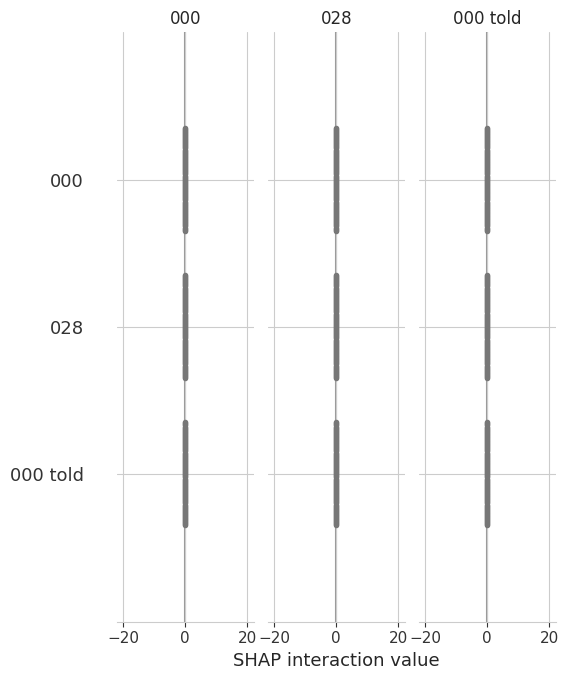


📊 SHAP Summary Plot (Per Class)

   • Class: Negative


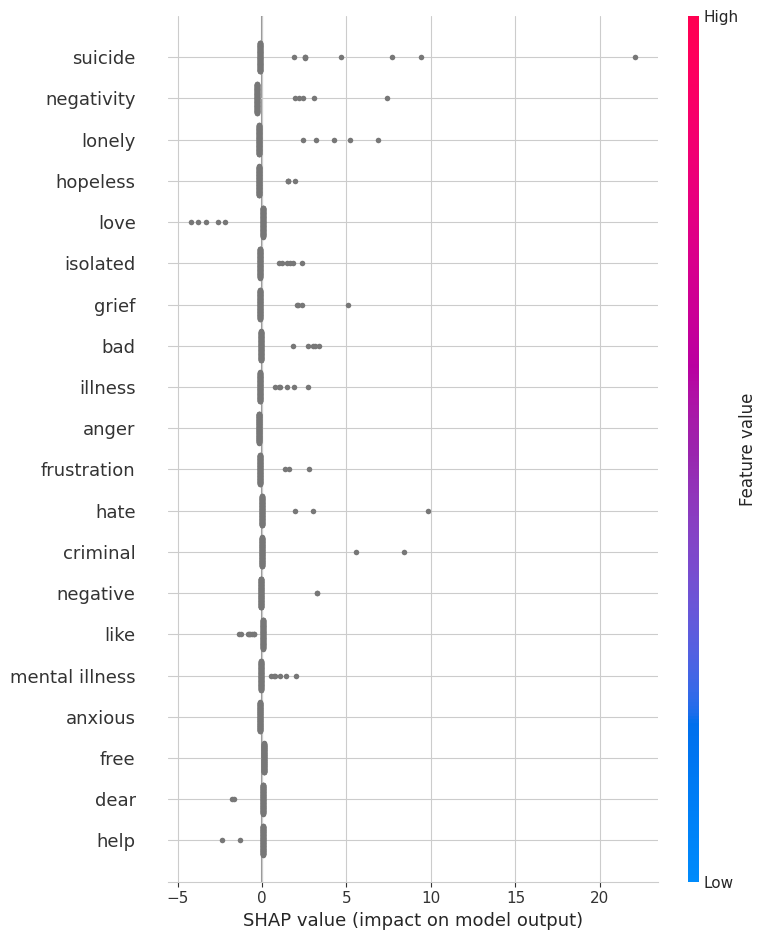


   • Class: Neutral


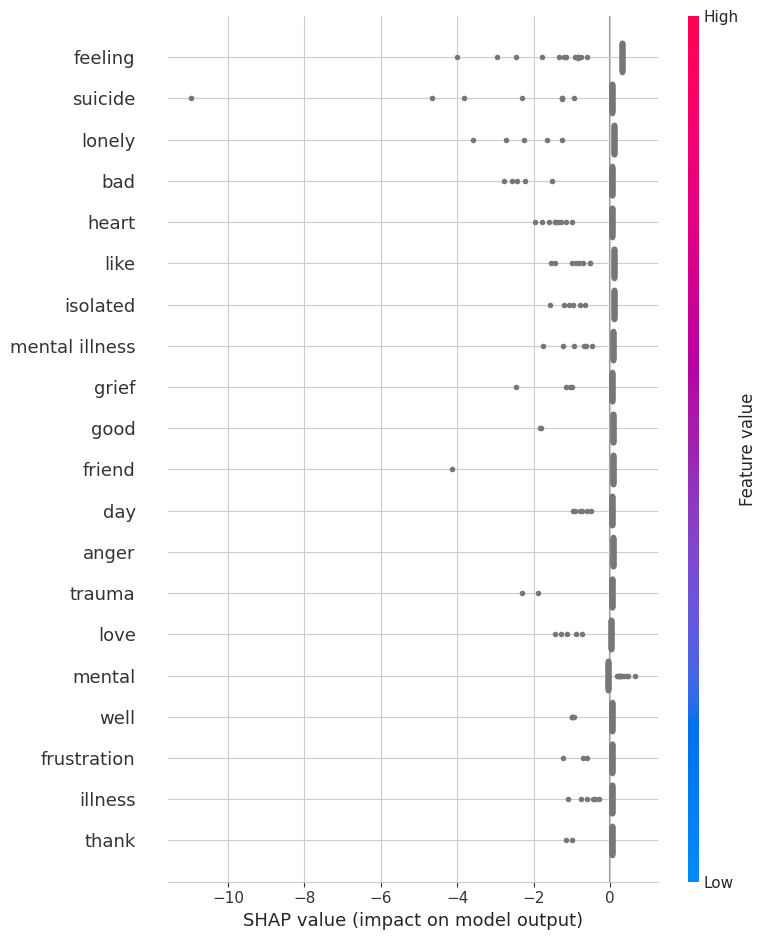


   • Class: Positive


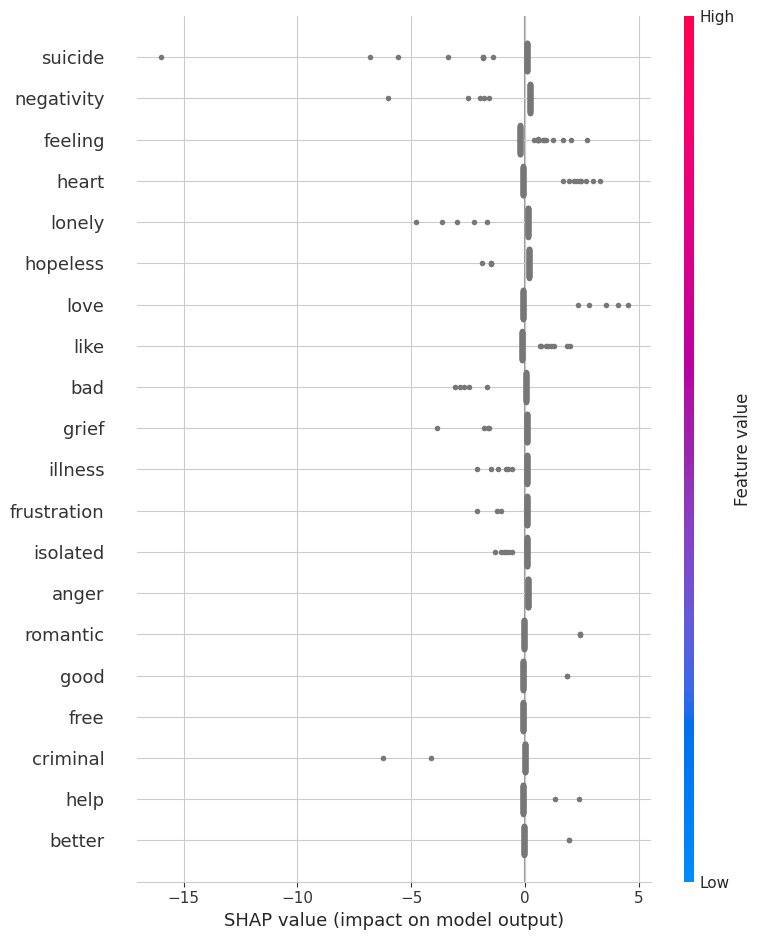


📊 SHAP Force Plot for example index 0 (Prediction: Negative)


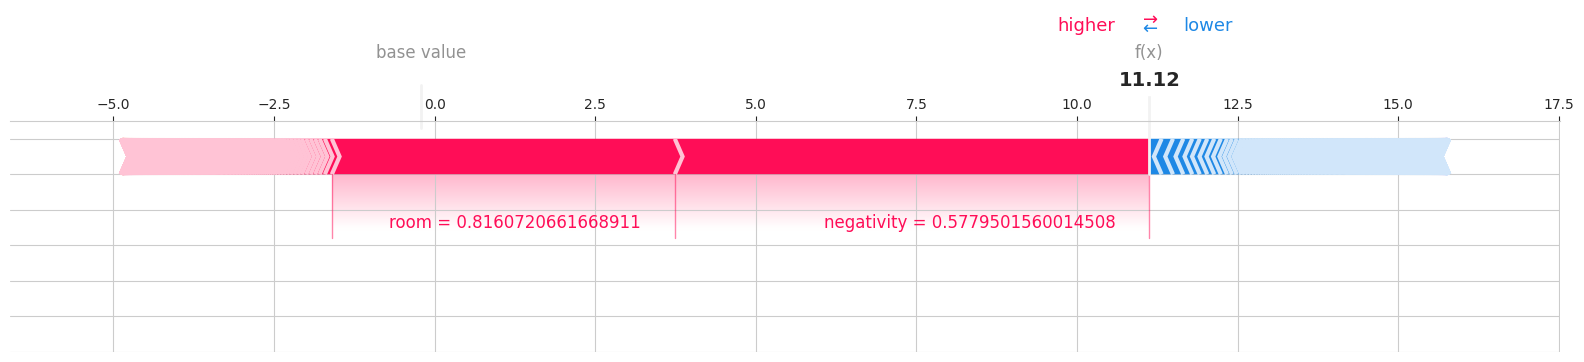

In [42]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_v.get_feature_names_out()

# 1. Summary plot for all classes combined
print("📊 SHAP Summary Plot (All Classes)")
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, class_names=encoder.classes_)

# 2. Summary plot for each class individually
print("\n📊 SHAP Summary Plot (Per Class)")
for i, class_name in enumerate(encoder.classes_):
    print(f"\n   • Class: {class_name}")
    shap.summary_plot(shap_values[:, :, i], X_test_sample, feature_names=feature_names, title=f'SHAP Summary Plot for {class_name}')

# 3. Force plot for a specific example
idx_to_explain = 0 # Choose an example index from the test sample (0 to 99)
print(f"\n📊 SHAP Force Plot for example index {idx_to_explain} (Prediction: {encoder.inverse_transform([np.argmax(pac.predict(X_test_sample[idx_to_explain]))])[0]})")

# Get the base value for the explainer
base_value = explainer.expected_value

# If base_value is a list or array, select the value for the predicted class
if isinstance(base_value, (list, np.ndarray)):
    predicted_class_idx = np.argmax(pac.predict(X_test_sample[idx_to_explain]))
    selected_base_value = base_value[predicted_class_idx]
else:
    selected_base_value = base_value # Use the single value if not multi-output

# Get the SHAP values for the specific example and predicted class
example_shap_values = shap_values[idx_to_explain, :, predicted_class_idx]

# Get the test sample data for the specific example
example_data = X_test_sample[idx_to_explain]

# Ensure example_data is in a format compatible with force_plot (e.g., a dense numpy array or DataFrame row)
# Since X_test_sample is a sparse matrix, convert the specific row to a dense numpy array
example_data_dense = example_data.toarray()[0]


shap.force_plot(
    selected_base_value,
    example_shap_values,
    example_data_dense,
    feature_names=feature_names,
    matplotlib=True # Use matplotlib backend for plotting in notebooks
)